# Dimensionality Reduction(PCA) and Cell Type Classification of Lung Adenocarcinoma Single-Cell RNA-Seq Data

## Introduction

Single-cell RNA sequencing (scRNA-seq) has become a powerful approach for studying cellular heterogeneity in complex diseases such as cancer.  
By measuring gene expression at the individual cell level, scRNA-seq enables the identification of distinct cell populations, functional states, and tumor microenvironment components that are not detectable using bulk sequencing methods.

In this project, a publicly available lung adenocarcinoma scRNA-seq dataset (GSE131907) from the NCBI Gene Expression Omnibus (GEO) was analyzed to explore cell-level variation and cell type classification.  
Due to the high dimensionality of gene expression data, Principal Component Analysis (PCA) was applied to reduce dimensionality and facilitate visualization and modeling.

The project further integrates biological cell annotations with machine learning techniques to build a supervised classification model for predicting cell types based on reduced-dimensional features.  
This end-to-end workflow demonstrates practical bioinformatics and data science skills, including large-scale data handling, dimensionality reduction, visualization, and interpretable machine learning applied to single-cell genomics.

This work was developed by adapting an exercise from the Coursera course *Introduction to Bioinformatics* offered by the Birla Institute of Technology & Science (BITS), Pilani.

### Loading Required Libraries

This cell imports the core Python libraries used throughout the analysis.  
- **pandas** is used for loading, manipulating, and managing large gene expression datasets.  
- **PCA** from *scikit-learn* is used to perform dimensionality reduction on high-dimensional single-cell RNA-seq data.  
- **matplotlib.pyplot** is used to create visualizations such as PCA scatter plots and explained variance plots.

In [1]:
## Loading Libraries
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Loading the Gene Expression Dataset

It loads a preprocessed single-cell RNA sequencing dataset from the NCBI GEO accession **GSE131907**, which contains lung adenocarcinoma samples.  
The dataset includes expression profiles from tens of thousands of cells derived from multiple patients.  
The data is stored in **Feather format**, which allows fast loading and efficient handling of large-scale gene expression matrices.

In [2]:
# Loading Data
#### NCBI GSE Accession Number: GSE131907 
#### Lung Cancer Data
#### 208,506 cells 
#### 58 lung adenocarcinomas from 44 patients

file_path = "sampled_expression_matrix_30k-Copy1.feather"
data = pd.read_feather(file_path)

### Note on Dataset Availability and Reproducibility

This repository uses a **sampled subset** of the original GSE131907 dataset due to GitHub file size limitations.  
The full dataset is large and cannot be directly uploaded to this repository.

To reproduce the analysis:
1. Download the original dataset from the NCBI GEO database (GSE131907).
2. Sample a subset of cells from the original expression matrix.
3. Convert the sampled data into **Feather format** for efficient storage and fast loading.
4. Place the generated Feather file in the repository and update the file path accordingly.

The original dataset can be accessed from the official source:  
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE131907

### Setting Gene Identifiers as the Index

This cell checks whether a **Gene_ID** column exists in the dataset and, if present, sets it as the DataFrame index.  
Using gene identifiers as the index ensures that each row uniquely represents a gene, which is a standard format for gene expression matrices and simplifies downstream analysis.

In [3]:
## Setting gene_Id as index
if "Gene_ID" in data.columns:
    data.set_index("Gene_ID", inplace=True)

### Inspecting Dataset Dimensions and Structure

It generates the shape of the gene expression matrix to verify its dimensions, which are expected to be in the format **genes × cells**.  
It also displays the first few rows of the dataset to provide a quick overview of the data structure and confirm that gene expression values have been loaded correctly.

In [4]:
## Display dimensiosn of the data
print(f"Data shape: {data.shape}")  # Expected format: genes x cells
print(data.head())

Data shape: (29634, 30000)
   CATCAGAAGTGTCCCG_LUNG_T06  CACTCCAAGTGCTGCC_LUNG_T18  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   CTCGAAACAAGGTTCT_EFFUSION_64  CCTATTATCAAGGCTT_LN_11  \
0                           0.0                     0.0   
1                           0.0                     0.0   
2                           0.0                     0.0   
3                           0.0                     0.0   
4                           0.0                     0.0   

   ATTTCTGTCACTTATC_EBUS_12  TCGCGAGAGATCGGGT_EBUS_13  GTAACTGCACCCTATC_LN_11  \
0                       0.0                       0.0                     0.0   
1                       0.0                       0.0                     0.0   
2                   

### Variance Filtering (Skipped)

Variance-based gene filtering was initially considered to remove low-variance genes
that contribute limited biological signal. However, due to memory constraints when
handling the high-dimensional RNA-seq dataset, this step was skipped.

PCA was performed directly on the normalized expression matrix. This approach is
commonly used for exploratory analysis such as sample or cell clustering, where
the primary goal is to capture global variance patterns rather than fine-grained
gene-level effects.

In [ ]:
# Calculating the variance of expression values
'''
gene_variances = data.var(axis=1)
threshold = 0.1  # Variance threshold
filtered_data = data.loc[gene_variances > threshold]
print(f"Filtered data shape: {filtered_data.shape}")
'''

### Transposing the Data for PCA

Then, the gene expression matrix is transposed so that rows represent **cells** and columns represent **genes**.  
This format is required for PCA, as scikit-learn expects observations (cells) as rows and features (genes) as columns.  
The printed shape confirms that the data is now structured as **cells × genes**.

In [21]:
# Transposing data for PCA compatibility
transposed_data = data.T
print(f"Transposed data shape: {transposed_data.shape}")  # Expected format: cells x filtered genes

Transposed data shape: (30000, 29634)


The transposed dataset has a shape of **(30,000 cells × 29,634 genes)**.  
This highlights the high dimensionality typical of single-cell RNA-seq data, where each cell is characterized by expression levels of tens of thousands of genes, motivating the use of dimensionality reduction techniques such as PCA.

### Principal Component Analysis (PCA)

This cell applies **Principal Component Analysis (PCA)** to reduce the high-dimensional gene expression data into a lower-dimensional space.  
The data is projected onto **50 principal components**, capturing the major sources of variation across cells while reducing noise and computational complexity.  
The randomized SVD solver is used to improve efficiency when handling large-scale single-cell datasets.

In [22]:
# PCA implementation
pca = PCA(n_components=50, svd_solver="randomized")  # Reduce to 50 components
pca_result = pca.fit_transform(transposed_data)

In [ ]:
#check the shpe of pca_result
pca_result.shape

(30000, 50)

The PCA result has a shape of **(30,000 cells × 50 principal components)**.  
This confirms that the original high-dimensional gene expression data has been successfully compressed into a lower-dimensional representation while preserving the main sources of biological variation across cells.


### Saving PCA Results

The PCA output is converted into a structured DataFrame, where each column represents a principal component and each row corresponds to a single cell.  
Cell identifiers are added to maintain traceability between PCA results and the original cells.  
The resulting table is saved as a CSV file, enabling reuse of the reduced-dimensional data in downstream analyses and visualizations.

In [ ]:
# Saving PCA data
pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pca_df["Cell_ID"] = transposed_data.index
pca_df.to_csv("pca_results.csv", index=False)
print("PCA results saved as 'pca_results.csv'")

PCA results saved as 'pca_results.csv'


### PCA Scatter Plot (PC1 vs PC2)

This cell visualizes the distribution of cells along the first two principal components.  
PC1 and PC2 capture the largest sources of variance in the dataset, allowing an initial assessment of cell-to-cell variability and potential clustering patterns driven by underlying biological differences.

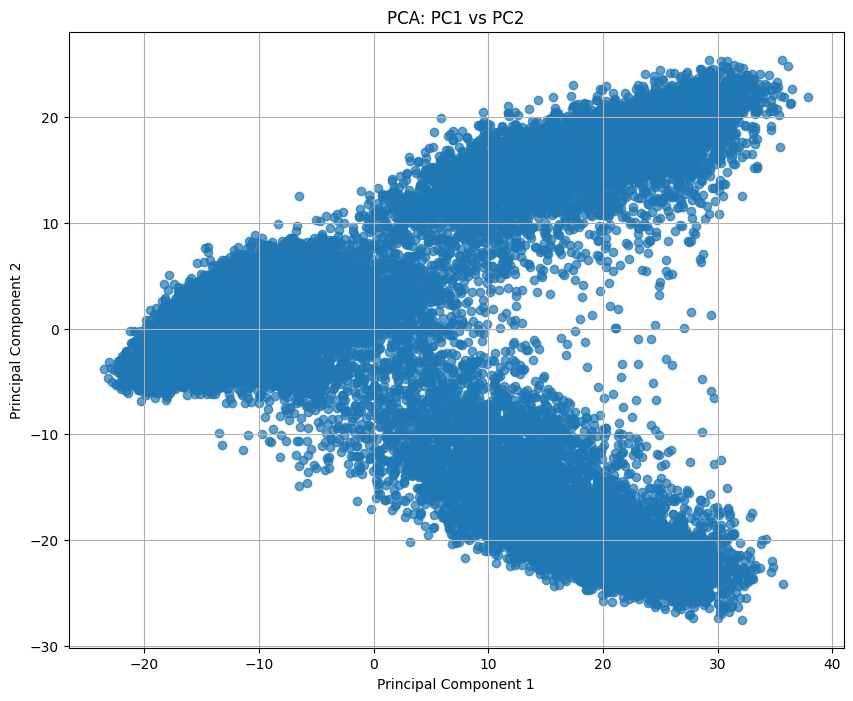

In [25]:
## Plotting principal components (PC1 vs PC2)
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.title("PCA: PC1 vs PC2")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

### Loading Cell Annotation Metadata

This cell loads the cell-level annotation file associated with the GSE131907 dataset.  
The annotation table contains biological metadata for each cell, such as cell type labels, which are essential for interpreting PCA results and for downstream supervised learning tasks.

In [27]:
## Load cell annotations data
annotation_file = "GSE131907_Lung_Cancer_cell_annotation.txt"
cell_annotations = pd.read_csv(annotation_file, sep="\t")

### Merging PCA Results with Cell Annotations
Then, I combine the PCA-derived features with the corresponding biological annotations for each cell.  
By merging on the cell identifiers, each cell’s low-dimensional representation is linked to its annotated metadata, enabling biologically meaningful visualization and supervised classification based on cell types.

In [28]:
## Merge PCA results with cell annotations
pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pca_df["Cell_ID"] = transposed_data.index
annotated_pca_df = pca_df.merge(cell_annotations, how="inner", left_on="Cell_ID", right_on="Index")

### PCA Visualization Colored by Cell Type
It visualizes the first two principal components while coloring each cell by its **refined cell type annotation**.  
By overlaying biological labels onto the PCA space, this plot allows assessment of how well different cell types separate based on their gene expression profiles and whether PCA captures biologically meaningful variation.

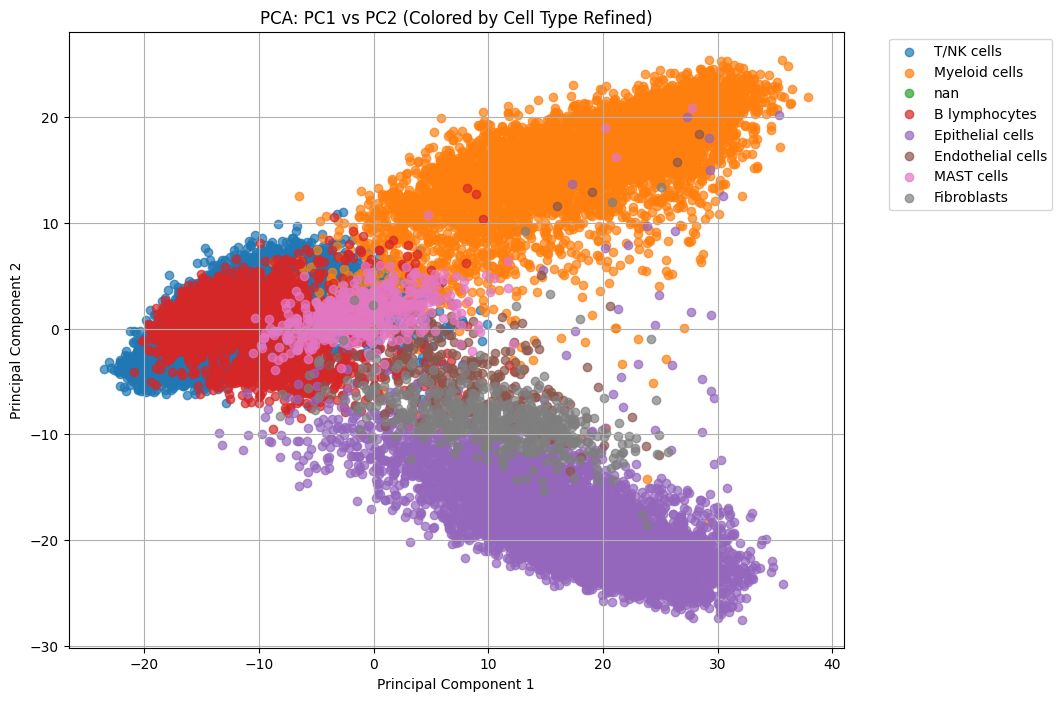

In [29]:
## Plot PCA results (PC1 vs PC2) colored by cell type
plt.figure(figsize=(10, 8))
for cell_type in annotated_pca_df["Cell_type.refined"].unique():
    subset = annotated_pca_df[annotated_pca_df["Cell_type.refined"] == cell_type]
    plt.scatter(subset["PC1"], subset["PC2"], label=cell_type, alpha=0.7)

plt.title("PCA: PC1 vs PC2 (Colored by Cell Type Refined)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()

## Decision Tree Classification

### Importing Libraries for Decision Tree Classification

This cell imports the necessary scikit-learn utilities for supervised machine learning.  
- **train_test_split** is used to divide the data into training and testing sets.  
- **DecisionTreeClassifier** is used to build a classification model that predicts cell types based on PCA features.  
- **plot_tree** allows visualization of the trained decision tree to interpret how classification decisions are made.

In [ ]:
#import necessary libraries for decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

### Preparing Data for Supervised Learning

The PCA feature matrix is merged with the corresponding cell annotation metadata.  
The resulting dataset contains both the reduced-dimensional features (principal components) and the true cell type labels, making it suitable for training and evaluating a supervised classification model.

In [30]:
# Merge PCA results with annotations
merged_df = pd.merge(pca_df, cell_annotations, left_on="Cell_ID", right_on="Index")

### Defining Features and Target Variables

This cell separates the dataset into input features and target labels for classification.  
The **features (X)** consist of the PCA components, which provide a compact numerical representation of each cell.  
The **target variable (y)** contains the annotated cell type labels that the model aims to predict.  
The printed shapes confirm that the features and labels are correctly aligned.

In [43]:
# Define features (PCA components) and target (cell types)
X = merged_df[[col for col in merged_df.columns if col.startswith("PC")]]  # PCA components
y = merged_df["Cell_type"]  # Replace "Cell_type" with the appropriate column name in your dataset

print(f"Features shape: {X.shape}, Target shape: {y.shape}")

Features shape: (30000, 50), Target shape: (30000,)


### Splitting Data into Training and Test Sets

This cell divides the dataset into training and testing subsets.  
Seventy percent of the data is used to train the model, while thirty percent is reserved for testing its performance on unseen cells.  
Setting a fixed random state ensures reproducibility of the split.

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (21000, 50), Test set: (9000, 50)


### Training the Decision Tree Classifier

This cell initializes and trains a **Decision Tree classifier** using the PCA-derived features from the training set.  
The model learns decision rules that map patterns in the reduced-dimensional gene expression data to the corresponding cell type labels.

In [35]:
# Train the decision tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Evaluating Model Performance

Now, the trained decision tree classifier is evaluated on the test set.  
The reported accuracy represents the proportion of cells whose types were correctly predicted, providing an initial measure of the model’s classification performance on unseen data.

In [37]:
# Evaluate the decision tree on the test set
test_accuracy = decision_tree.score(X_test, y_test)
print(f"Testset Accuracy: {test_accuracy:.2f}")

Testset Accuracy: 0.96


### Visualizing the Decision Tree Model

This cell visualizes the trained decision tree to illustrate how the model makes classification decisions.  
Each node represents a split based on a principal component, and the branches show how cells are progressively separated into different cell types.  
Limiting the tree depth improves interpretability and helps highlight the most important decision rules learned from the data.

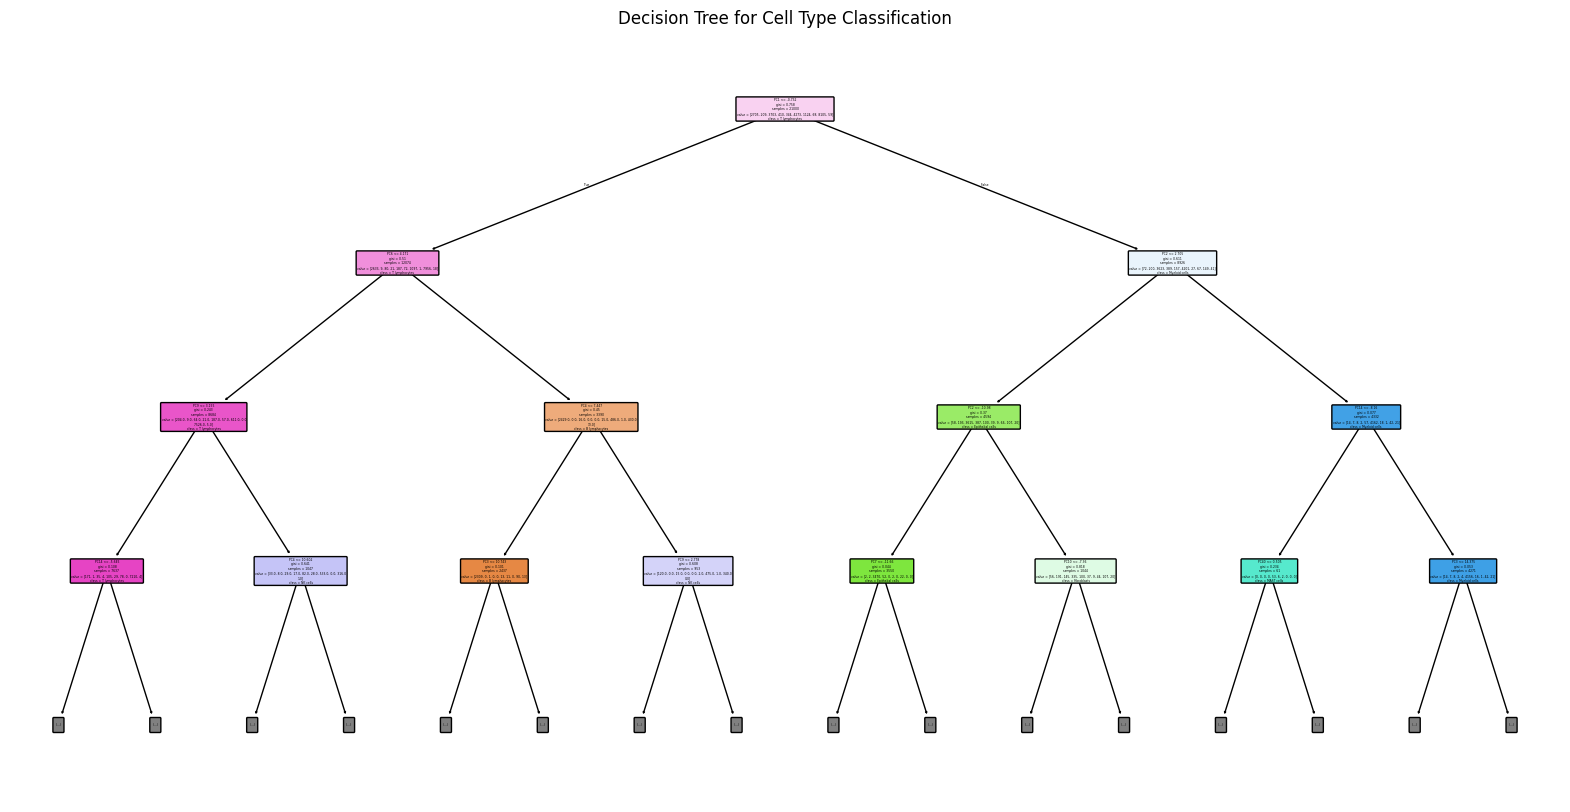

In [36]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree,
    feature_names=X.columns,  # Names of PCA components
    class_names=decision_tree.classes_,  # Cell type labels
    filled=True,  # Color nodes based on predicted class
    rounded=True,  # Rounded edges for better aesthetics
    max_depth=3  # Limit depth for clarity
)
plt.title("Decision Tree for Cell Type Classification")
plt.show()

### Importing Evaluation and Visualization Libraries

This cell imports additional scikit-learn and visualization tools used to evaluate the classification model.  
These libraries enable detailed performance assessment through metrics such as classification reports, confusion matrices, and ROC curves, as well as clear visualizations using heatmaps.

In [ ]:
# Laod libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

### Generating Predictions on the Test Set
The trained decision tree model is used to generate predictions for the test data.  
- **y_pred** contains the predicted cell type labels for each test cell.  
- **y_proba** contains the predicted class probabilities, which are useful for probabilistic evaluation metrics such as ROC and AUC analysis.

In [40]:
# Predict on the test set
y_pred = decision_tree.predict(X_test)
y_proba = decision_tree.predict_proba(X_test)

### Classification Report

A detailed classification report for the test set predictions is generated. 
The report summarizes model performance for each cell type using metrics such as **precision**, **recall**, **F1-score**, and **support**, providing a more comprehensive evaluation than accuracy alone.

In [41]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                   precision    recall  f1-score   support

    B lymphocytes       0.96      0.98      0.97      1176
Endothelial cells       0.85      0.87      0.86        77
 Epithelial cells       0.99      0.98      0.98      1615
      Fibroblasts       0.90      0.90      0.90       166
       MAST cells       0.96      0.91      0.93       148
    Myeloid cells       0.97      0.98      0.97      1775
         NK cells       0.85      0.85      0.85       498
 Oligodendrocytes       0.95      0.95      0.95        37
    T lymphocytes       0.97      0.97      0.97      3475
     Undetermined       0.59      0.61      0.60        33

         accuracy                           0.96      9000
        macro avg       0.90      0.90      0.90      9000
     weighted avg       0.96      0.96      0.96      9000



### Confusion Matrix Visualization

This cell computes and visualizes the confusion matrix for the decision tree classifier.  
The confusion matrix shows the number of correct and incorrect predictions for each cell type, allowing identification of classes that are well classified versus those that are frequently misclassified.  
The heatmap representation improves interpretability by highlighting patterns of confusion between different cell types.

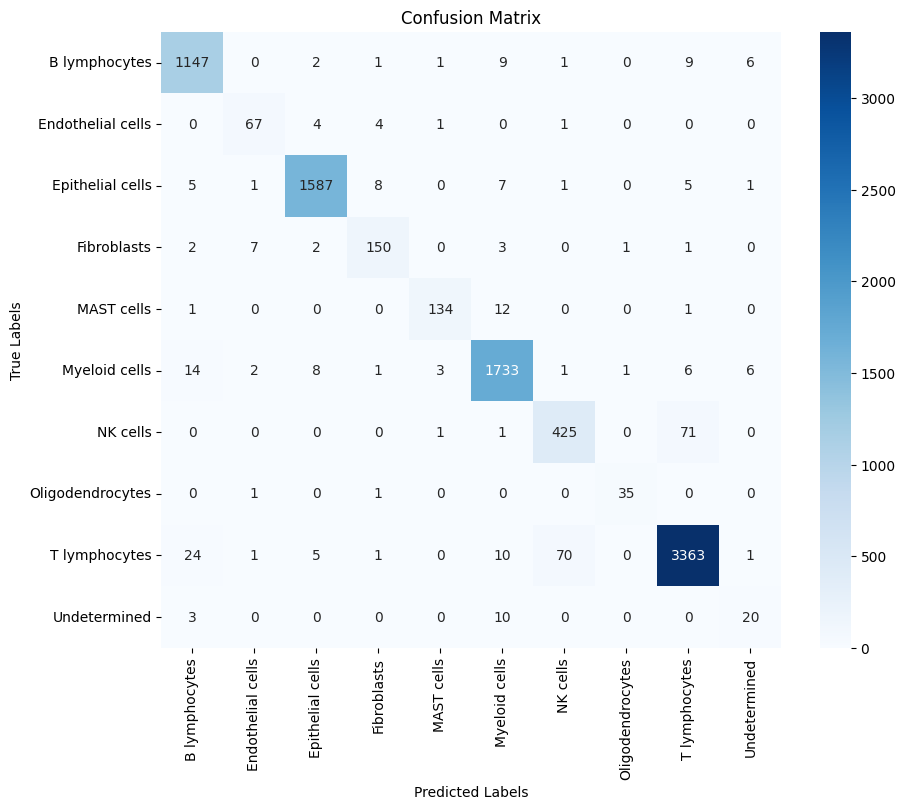

In [42]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=decision_tree.classes_, yticklabels=decision_tree.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Conclusion

In this project, a single-cell RNA-sequencing dataset from lung adenocarcinoma samples (GSE131907) was analyzed to explore cellular heterogeneity and cell type classification.  
High-dimensional gene expression data were first reduced using Principal Component Analysis (PCA), enabling efficient visualization and downstream analysis while preserving key biological variation across cells.

By integrating PCA features with curated cell annotations, the analysis demonstrated that major cell types exhibit distinct patterns in the reduced-dimensional space.  
A supervised machine learning approach using a Decision Tree classifier was then applied to predict cell types based on PCA components, achieving meaningful classification performance and offering interpretable decision rules.

Overall, this project showcases an end-to-end bioinformatics workflow combining dimensionality reduction, biological interpretation, and machine learning for single-cell data analysis.  
It highlights the practical use of data science techniques to extract biologically relevant insights from large-scale genomic datasets and serves as a foundation for more advanced models and analyses in single-cell transcriptomics.